# Question 1

# 1 a

1. Text Preprocessing:
    1. Tokenization
    2. Convert to lowercase
    3. Expand contractions
    4. Remove punctuation
    5. Apply lemmatization/stemming

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import pandas as pd

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Preprocessing function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove hashtags, mentions, and special characters
    text = re.sub(r'@\w+|#\w+|[^a-zA-Z\s]', '', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Join tokens back into a string
    return ' '.join(tokens)



# Reload the CSV file
data = pd.read_csv("train_data_tweet_AV.csv")

# Reapply the alternative preprocessing steps
data['processed_tweet'] = data['tweet'].apply(preprocess_text)

# Display a sample of the processed data
data[['tweet', 'processed_tweet']].head()

[nltk_data] Downloading package punkt to /Users/spartan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/spartan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/spartan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,tweet,processed_tweet
0,#fingerprint #Pregnancy Test https://goo.gl/h1...,test
1,Finally a transparant silicon case ^^ Thanks t...,finally transparant silicon case thanks uncle
2,We love this! Would you go? #talk #makememorie...,love would go
3,I'm wired I know I'm George I was made that wa...,im wired know im george made way
4,What amazing service! Apple won't even talk to...,amazing service apple wont even talk question ...


# b

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, GRU, Dense, Bidirectional, SimpleRNN, Dropout
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential


In [3]:
# Split the data into features and labels
X = data['processed_tweet']
y = data['label']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Create TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()


In [5]:
from gensim.models import Word2Vec

# Tokenize the data for Word2Vec
tokenized_train = [sentence.split() for sentence in X_train]
tokenized_test = [sentence.split() for sentence in X_test]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_train, vector_size=100, window=5, min_count=1)

# Create Word2Vec embeddings for the dataset
def create_word2vec_features(tokenized_data, model):
    return np.array([
        np.mean([model.wv[word] for word in words if word in model.wv] or [np.zeros(100)], axis=0)
        for words in tokenized_data
    ])

X_train_word2vec = create_word2vec_features(tokenized_train, word2vec_model)
X_test_word2vec = create_word2vec_features(tokenized_test, word2vec_model)


In [6]:
## Downoading the the pre-trained Glove model and unziping it 

In [7]:
# Load GloVe embeddings
glove_path = 'glove.6B/glove.6B.100d.txt'
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

# Create GloVe embeddings for the dataset
def create_glove_features(tokenized_data, embeddings):
    return np.array([
        np.mean([embeddings.get(word, np.zeros(100)) for word in words] or [np.zeros(100)], axis=0)
        for words in tokenized_data
    ])

X_train_glove = create_glove_features(tokenized_train, glove_embeddings)
X_test_glove = create_glove_features(tokenized_test, glove_embeddings)


# Building 4 diffrent for 3 different Representation

In [8]:
def build_sequential_model(input_dim=None, input_length=None, model_type='LSTM', is_sequence=False):
    model = Sequential()
    if is_sequence:
        # Use Embedding layer for tokenized input (sequence)
        model.add(Embedding(input_dim=input_dim, output_dim=100, input_length=input_length))
        if model_type == 'LSTM':
            model.add(LSTM(128))
        elif model_type == 'GRU':
            model.add(GRU(128))
        elif model_type == 'RNN':
            model.add(SimpleRNN(128))
        elif model_type == 'BiLSTM':
            model.add(Bidirectional(LSTM(128)))
    else:
        # Use Dense layers for vectorized input (e.g., TF-IDF, Word2Vec, GloVe)
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [9]:
from keras.layers import Embedding, LSTM, GRU, SimpleRNN, Bidirectional, Dense, Dropout
from keras.models import Sequential

def build_sequential_model(input_dim=None, input_length=None, model_type='LSTM', is_sequence=False):
    model = Sequential()
    if is_sequence:
        # Explicitly define the input shape in the Embedding layer
        model.add(Embedding(input_dim=input_dim, output_dim=100, input_length=input_length))
        if model_type == 'LSTM':
            model.add(LSTM(128, input_shape=(input_length, 100)))
        elif model_type == 'GRU':
            model.add(GRU(128, input_shape=(input_length, 100)))
        elif model_type == 'RNN':
            model.add(SimpleRNN(128, input_shape=(input_length, 100)))
        elif model_type == 'BiLSTM':
            model.add(Bidirectional(LSTM(128, input_shape=(input_length, 100))))
    else:
        # Use Dense layers for vectorized input (e.g., TF-IDF, Word2Vec, GloVe)
        model.add(Dense(128, activation='relu', input_dim=input_dim))
        model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define input dimensions
input_dim = 5000  # Vocabulary size
input_length = 100  # Sequence length

# Iterate over all model types
model_types = ['LSTM', 'GRU', 'RNN', 'BiLSTM']

# Display summaries for all models
for model_type in model_types:
    print(f"\nModel Summary for: {model_type}")
    print("-" * 50)
    model = build_sequential_model(input_dim=input_dim, input_length=input_length, model_type=model_type, is_sequence=True)
    model.build(input_shape=(None, input_length))  # Explicitly build the model
    model.summary()



Model Summary for: LSTM
--------------------------------------------------


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-11-23 16:22:29.148798: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-11-23 16:22:29.148870: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-11-23 16:22:29.148886: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-11-23 16:22:29.148961: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-23 16:22:29.148989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/opt/an

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 617,377 (2.36 MB)

 Trainable params: 617,377 (2.36 MB)

 Non-trainable params: 0 (0.00 B)


Model Summary for: GRU
--------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 588,449 (2.24 MB)

 Trainable params: 588,449 (2.24 MB)

 Non-trainable params: 0 (0.00 B)


Model Summary for: RNN
--------------------------------------------------


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 128)            │        29,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 529,441 (2.02 MB)

 Trainable params: 529,441 (2.02 MB)

 Non-trainable params: 0 (0.00 B)


Model Summary for: BiLSTM
--------------------------------------------------


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 100, 100)       │       500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 734,753 (2.80 MB)

 Trainable params: 734,753 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
from keras.callbacks import Callback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

class MetricsCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_X, val_y = self.validation_data
        predictions = (self.model.predict(val_X) > 0.5).astype(int)
        accuracy = accuracy_score(val_y, predictions)
        precision = precision_score(val_y, predictions)
        recall = recall_score(val_y, predictions)
        f1 = f1_score(val_y, predictions)
        print(f"Epoch {epoch + 1} - Loss: {logs['loss']:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

In [11]:
def train_evaluate_model(X_train, X_test, y_train, y_test, model_type, representation_type, is_sequence=False):
    if is_sequence:
        input_dim = len(tokenizer.word_index) + 1
        input_length = X_train.shape[1]
        model = build_sequential_model(input_dim=input_dim, input_length=input_length, model_type=model_type, is_sequence=True)
    else:
        input_dim = X_train.shape[1]
        model = build_sequential_model(input_dim=input_dim, model_type=model_type, is_sequence=False)
    
    # Instantiate the custom callback
    metrics_callback = MetricsCallback(validation_data=(X_test, y_test))
    
    # Train the model
    model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        verbose=1,
        callbacks=[metrics_callback]
    )
    
    # Final Predictions for Testing Set
    predictions = (model.predict(X_test) > 0.5).astype(int)
    
    # Calculate final metrics
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    
    return accuracy, precision, recall, f1


In [12]:
# Tokenized sequences for sequential models
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=100)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=100)

# Update representation dictionary
representations = {
    'TF-IDF': (X_train_tfidf, X_test_tfidf, False),
    'Word2Vec': (X_train_word2vec, X_test_word2vec, False),
    'GloVe': (X_train_glove, X_test_glove, False),
}
models = ['RNN', 'LSTM', 'GRU', 'BiLSTM']


In [13]:
results = []

for rep_name, (X_train_rep, X_test_rep, is_sequence) in representations.items():
    for model_name in models:
        try:
            acc, precision, recall, f1 = train_evaluate_model(
                X_train_rep, X_test_rep, y_train, y_test, model_name, rep_name, is_sequence
            )
            results.append({
                'Representation': rep_name,
                'Model': model_name,
                'Accuracy': acc,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1
            })
        except Exception as e:
            results.append({
                'Representation': rep_name,
                'Model': model_name,
                'Error': str(e)
            })

Epoch 1/10


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-11-23 16:22:36.667018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.7510 - loss: 0.5
Epoch 1 - Loss: 0.5057, Accuracy: 0.8239, Precision: 0.8228, Recall: 0.4514, F1-Score: 0.5830
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7513 - loss: 0.5858
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.8787 - loss: 0.
Epoch 2 - Loss: 0.2903, Accuracy: 0.8573, Precision: 0.7910, Recall: 0.6481, F1-Score: 0.7125
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8787 - loss: 0.3009
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.9231 - loss: 0.
Epoch 3 - Loss: 0.2086, Accuracy: 0.8649, Precision: 0.7711, Recall: 0.7176, F1-Score: 0.7434
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9230 - loss: 0.2052
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.9452 - loss: 0.1
Epoch 4 - Loss: 0.1615, Accuracy: 0.8617, Precision: 0.7825, Recall: 0.6829, F1-Score: 0.7293
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9452 - loss: 0.1559
Epoch

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7371 - loss: 0.5
Epoch 1 - Loss: 0.5037, Accuracy: 0.8251, Precision: 0.8326, Recall: 0.4491, F1-Score: 0.5835
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7379 - loss: 0.5846
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.8769 - loss: 0.31
Epoch 2 - Loss: 0.2928, Accuracy: 0.8617, Precision: 0.7886, Recall: 0.6736, F1-Score: 0.7266
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8771 - loss: 0.3102
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.9228 - loss: 0.
Epoch 3 - Loss: 0.2117, Accuracy: 0.8630, Precision: 0.7749, Recall: 0.7014, F1-Score: 0.7363
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9228 - loss: 0.2082
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.9471 - loss: 0.
Epoch 4 - Loss: 0.1635, Accuracy: 0.8592, Precision: 0.7714, Recall: 0.6875, F1-Score: 0.7271
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9470 - loss: 0.1554
Epoc

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7392 - loss: 0.5
Epoch 1 - Loss: 0.5058, Accuracy: 0.8365, Precision: 0.8240, Recall: 0.5093, F1-Score: 0.6295
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7404 - loss: 0.5850
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.8745 - loss: 0.
Epoch 2 - Loss: 0.2913, Accuracy: 0.8681, Precision: 0.7866, Recall: 0.7083, F1-Score: 0.7454
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8746 - loss: 0.3146
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.9250 - loss: 0.
Epoch 3 - Loss: 0.2100, Accuracy: 0.8580, Precision: 0.7851, Recall: 0.6597, F1-Score: 0.7170
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9249 - loss: 0.2088
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.9485 - loss: 0.
Epoch 4 - Loss: 0.1635, Accuracy: 0.8630, Precision: 0.7641, Recall: 0.7199, F1-Score: 0.7414
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9484 - loss: 0.1585
Epoch 

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.7387 - loss: 0.5
Epoch 1 - Loss: 0.5053, Accuracy: 0.8346, Precision: 0.8148, Recall: 0.5093, F1-Score: 0.6268
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7389 - loss: 0.5834
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.8822 - loss: 0.
Epoch 2 - Loss: 0.2910, Accuracy: 0.8586, Precision: 0.7781, Recall: 0.6736, F1-Score: 0.7221
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8822 - loss: 0.3005
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.9238 - loss: 0.20
Epoch 3 - Loss: 0.2103, Accuracy: 0.8567, Precision: 0.7839, Recall: 0.6551, F1-Score: 0.7137
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9238 - loss: 0.2057
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.9457 - loss: 0.15
Epoch 4 - Loss: 0.1628, Accuracy: 0.8617, Precision: 0.7781, Recall: 0.6898, F1-Score: 0.7313
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9455 - loss: 0.1587
Ep

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7348 - loss: 0.6
Epoch 1 - Loss: 0.5716, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7349 - loss: 0.6078
Epoch 2/10
 30/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7528 - loss: 0.5212

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.7532 - loss: 0.51
Epoch 2 - Loss: 0.5180, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7532 - loss: 0.5175
Epoch 3/10
 12/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7588 - loss: 0.5183

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.7551 - loss: 0.50
Epoch 3 - Loss: 0.5095, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7550 - loss: 0.5061
Epoch 4/10
 29/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7296 - loss: 0.5256

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.7394 - loss: 0.51
Epoch 4 - Loss: 0.5081, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7399 - loss: 0.5148
Epoch 5/10
 29/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7560 - loss: 0.4772

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7476 - loss: 0.50
Epoch 5 - Loss: 0.5061, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7476 - loss: 0.5025
Epoch 6/10
 21/198 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7241 - loss: 0.5499

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.7441 - loss: 0.51
Epoch 6 - Loss: 0.5057, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7442 - loss: 0.5141
Epoch 7/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7702 - loss: 0.4551

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.7576 - loss: 0.49
Epoch 7 - Loss: 0.5057, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7573 - loss: 0.4913
Epoch 8/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7417 - loss: 0.5156

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7465 - loss: 0.51
Epoch 8 - Loss: 0.5057, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7465 - loss: 0.5105
Epoch 9/10
 26/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7585 - loss: 0.4918

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.7474 - loss: 0.50
Epoch 9 - Loss: 0.5048, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7475 - loss: 0.5036
Epoch 10/10
 29/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7408 - loss: 0.5271

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 837us/step - accuracy: 0.7505 - loss: 0.50
Epoch 10 - Loss: 0.5046, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7505 - loss: 0.5041
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step
Epoch 1/10


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7361 - loss: 0.6
Epoch 1 - Loss: 0.5686, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7365 - loss: 0.6034
Epoch 2/10
 27/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7440 - loss: 0.5213

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.7418 - loss: 0.52
Epoch 2 - Loss: 0.5184, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7420 - loss: 0.5264
Epoch 3/10
 29/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7221 - loss: 0.5353

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.7440 - loss: 0.51
Epoch 3 - Loss: 0.5104, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7442 - loss: 0.5172
Epoch 4/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7412 - loss: 0.5177

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.7446 - loss: 0.51
Epoch 4 - Loss: 0.5093, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7447 - loss: 0.5155
Epoch 5/10
 29/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7175 - loss: 0.5269

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.7420 - loss: 0.51
Epoch 5 - Loss: 0.5072, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7422 - loss: 0.5111
Epoch 6/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7227 - loss: 0.5249

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.7459 - loss: 0.50
Epoch 6 - Loss: 0.5069, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7459 - loss: 0.5090
Epoch 7/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7605 - loss: 0.4758

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.7558 - loss: 0.49
Epoch 7 - Loss: 0.5058, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7556 - loss: 0.4994
Epoch 8/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7381 - loss: 0.5192

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.7431 - loss: 0.51
Epoch 8 - Loss: 0.5038, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7432 - loss: 0.5106
Epoch 9/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7576 - loss: 0.4829

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.7432 - loss: 0.50
Epoch 9 - Loss: 0.5042, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7435 - loss: 0.5052
Epoch 10/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7248 - loss: 0.5271

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.7429 - loss: 0.50
Epoch 10 - Loss: 0.5029, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7430 - loss: 0.5095
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step
Epoch 1/10


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7377 - loss: 0.6
Epoch 1 - Loss: 0.5746, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7381 - loss: 0.6074
Epoch 2/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7514 - loss: 0.5403

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.7476 - loss: 0.52
Epoch 2 - Loss: 0.5195, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7477 - loss: 0.5285
Epoch 3/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7723 - loss: 0.4803

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.7574 - loss: 0.50
Epoch 3 - Loss: 0.5100, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7571 - loss: 0.5015
Epoch 4/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7704 - loss: 0.4819

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.7559 - loss: 0.50
Epoch 4 - Loss: 0.5086, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7558 - loss: 0.5037
Epoch 5/10
 30/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7407 - loss: 0.5007

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.7474 - loss: 0.50
Epoch 5 - Loss: 0.5073, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7474 - loss: 0.5065
Epoch 6/10
 30/198 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7400 - loss: 0.5283

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7420 - loss: 0.51
Epoch 6 - Loss: 0.5065, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7420 - loss: 0.5145
Epoch 7/10
 31/198 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7507 - loss: 0.5224

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.7533 - loss: 0.50
Epoch 7 - Loss: 0.5062, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7531 - loss: 0.5021
Epoch 8/10
 30/198 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7712 - loss: 0.4821

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7523 - loss: 0.49
Epoch 8 - Loss: 0.5041, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7521 - loss: 0.4979
Epoch 9/10
 30/198 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7809 - loss: 0.4681

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/stepep - accuracy: 0.7519 - loss: 0.
Epoch 9 - Loss: 0.5039, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7519 - loss: 0.5000
Epoch 10/10
 30/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7385 - loss: 0.5147

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7443 - loss: 0.50
Epoch 10 - Loss: 0.5026, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7444 - loss: 0.5054
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step
Epoch 1/10


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step p - accuracy: 0.7299 - loss: 0.6
Epoch 1 - Loss: 0.5761, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.7306 - loss: 0.6108
Epoch 2/10
  6/198 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.7529 - loss: 0.5328 

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.7416 - loss: 0.53
Epoch 2 - Loss: 0.5198, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7418 - loss: 0.5297
Epoch 3/10
 10/198 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7725 - loss: 0.4709

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.7522 - loss: 0.51
Epoch 3 - Loss: 0.5114, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7520 - loss: 0.5102
Epoch 4/10
 26/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7421 - loss: 0.5020

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.7472 - loss: 0.50
Epoch 4 - Loss: 0.5083, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7472 - loss: 0.5075
Epoch 5/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7366 - loss: 0.5165

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.7430 - loss: 0.51
Epoch 5 - Loss: 0.5073, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7431 - loss: 0.5131
Epoch 6/10
 25/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7167 - loss: 0.5167

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7359 - loss: 0.51
Epoch 6 - Loss: 0.5063, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7363 - loss: 0.5151
Epoch 7/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7358 - loss: 0.5204

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/stepep - accuracy: 0.7449 - loss: 0.
Epoch 7 - Loss: 0.5056, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7449 - loss: 0.5085
Epoch 8/10
 26/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7545 - loss: 0.4991

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.7458 - loss: 0.50
Epoch 8 - Loss: 0.5050, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7459 - loss: 0.5054
Epoch 9/10
 30/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7577 - loss: 0.4973

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.7501 - loss: 0.50
Epoch 9 - Loss: 0.5054, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7500 - loss: 0.5041
Epoch 10/10
 28/198 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7497 - loss: 0.5126

/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.7494 - loss: 0.50
Epoch 10 - Loss: 0.5049, Accuracy: 0.7273, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7494 - loss: 0.5042
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step
Epoch 1/10


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7537 - loss: 0.5
Epoch 1 - Loss: 0.4506, Accuracy: 0.8314, Precision: 0.7538, Recall: 0.5671, F1-Score: 0.6473
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7555 - loss: 0.5146
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.8396 - loss: 0.36
Epoch 2 - Loss: 0.3528, Accuracy: 0.8472, Precision: 0.7513, Recall: 0.6574, F1-Score: 0.7012
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8399 - loss: 0.3689
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.8554 - loss: 0.32
Epoch 3 - Loss: 0.3283, Accuracy: 0.8472, Precision: 0.7596, Recall: 0.6435, F1-Score: 0.6967
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8554 - loss: 0.3237
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.8631 - loss: 0.31
Epoch 4 - Loss: 0.3150, Accuracy: 0.8460, Precision: 0.7541, Recall: 0.6458, F1-Score: 0.6958
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8631 - loss: 0.3128


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7386 - loss: 0.5
Epoch 1 - Loss: 0.4514, Accuracy: 0.8270, Precision: 0.7883, Recall: 0.5000, F1-Score: 0.6119
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7401 - loss: 0.5205
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.8390 - loss: 0.37
Epoch 2 - Loss: 0.3515, Accuracy: 0.8409, Precision: 0.7679, Recall: 0.5972, F1-Score: 0.6719
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8392 - loss: 0.3725
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.8522 - loss: 0.33
Epoch 3 - Loss: 0.3289, Accuracy: 0.8516, Precision: 0.7408, Recall: 0.7014, F1-Score: 0.7206
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8523 - loss: 0.3379
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 830us/step - accuracy: 0.8631 - loss: 0.31
Epoch 4 - Loss: 0.3184, Accuracy: 0.8504, Precision: 0.7762, Recall: 0.6343, F1-Score: 0.6981
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8630 - loss: 0.3159


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7682 - loss: 0.5
Epoch 1 - Loss: 0.4388, Accuracy: 0.8289, Precision: 0.7605, Recall: 0.5440, F1-Score: 0.6343
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7685 - loss: 0.5018
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.8457 - loss: 0.35
Epoch 2 - Loss: 0.3465, Accuracy: 0.8415, Precision: 0.7768, Recall: 0.5880, F1-Score: 0.6693
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8458 - loss: 0.3591
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.8623 - loss: 0.32
Epoch 3 - Loss: 0.3225, Accuracy: 0.8472, Precision: 0.7140, Recall: 0.7338, F1-Score: 0.7237
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8623 - loss: 0.3282
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.8643 - loss: 0.31
Epoch 4 - Loss: 0.3163, Accuracy: 0.8479, Precision: 0.7705, Recall: 0.6296, F1-Score: 0.6930
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8643 - loss: 0.3152


/opt/anaconda3/envs/tf-env/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step p - accuracy: 0.7190 - loss: 0.5
Epoch 1 - Loss: 0.4658, Accuracy: 0.8289, Precision: 0.7492, Recall: 0.5602, F1-Score: 0.6411
198/198 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7206 - loss: 0.5391
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.8412 - loss: 0.36
Epoch 2 - Loss: 0.3558, Accuracy: 0.8460, Precision: 0.7597, Recall: 0.6366, F1-Score: 0.6927
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8413 - loss: 0.3605
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.8496 - loss: 0.33
Epoch 3 - Loss: 0.3329, Accuracy: 0.8428, Precision: 0.7699, Recall: 0.6042, F1-Score: 0.6770
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8496 - loss: 0.3368
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.8593 - loss: 0.31
Epoch 4 - Loss: 0.3168, Accuracy: 0.8428, Precision: 0.7480, Recall: 0.6389, F1-Score: 0.6891
198/198 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8593 - loss: 0.3152


In [14]:
# Convert results to a DataFrame
results_df = pd.DataFrame(results)

In [15]:
results_df

,Representation,Model,Accuracy,Precision,Recall,F1-Score
0,TF-IDF,RNN,0.844066,0.728395,0.682870,0.704898
1,TF-IDF,LSTM,0.843434,0.724390,0.687500,0.705463
2,TF-IDF,GRU,0.839646,0.729381,0.655093,0.690244
3,TF-IDF,BiLSTM,0.840909,0.735602,0.650463,0.690418
4,Word2Vec,RNN,0.727273,0.000000,0.000000,0.000000
5,Word2Vec,LSTM,0.727273,0.000000,0.000000,0.000000
6,Word2Vec,GRU,0.727273,0.000000,0.000000,0.000000
7,Word2Vec,BiLSTM,0.727273,0.000000,0.000000,0.000000
8,GloVe,RNN,0.861111,0.774611,0.692130,0.731051
9,GloVe,LSTM,0.859848,0.782258,0.673611,0.723881


In [16]:
results_df.to_csv('output.csv')

In [17]:
import matplotlib.pyplot as plt

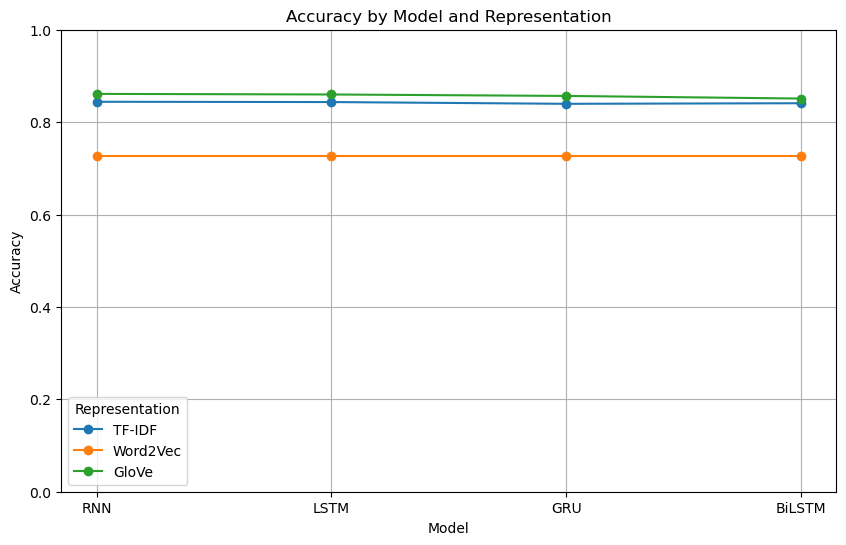

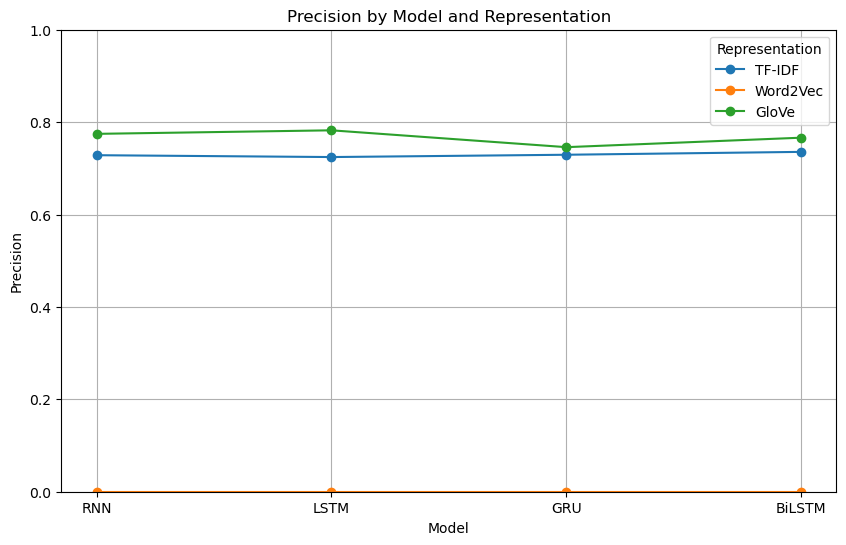

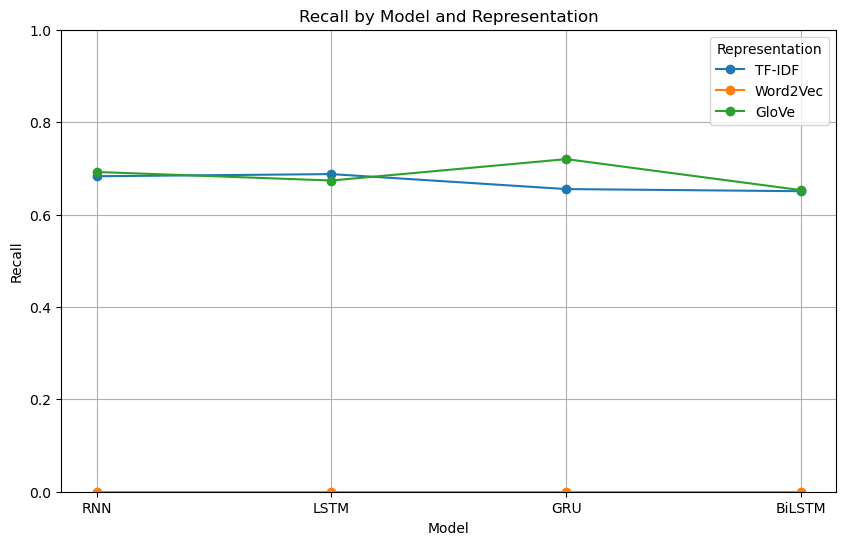

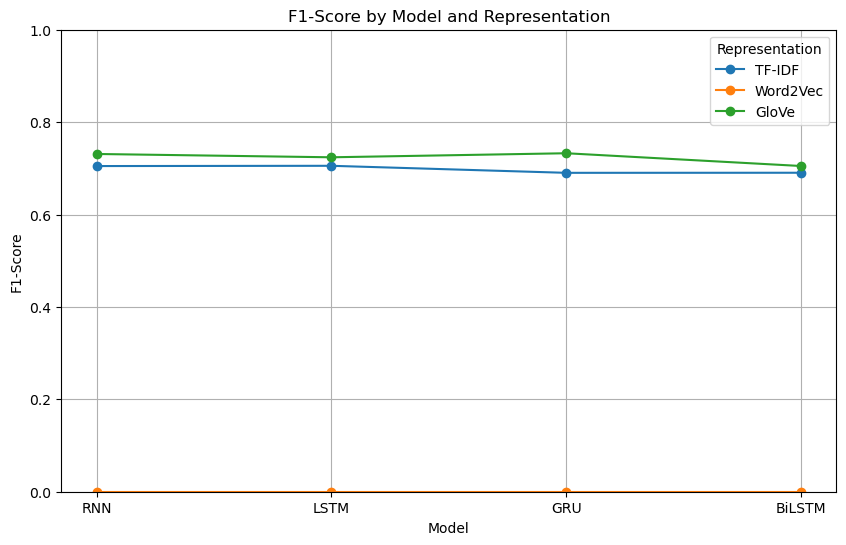

In [18]:
# Plot Accuracy, Precision, Recall, and F1-Score for each representation and model
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for representation in results_df["Representation"].unique():
        subset = results_df[results_df["Representation"] == representation]
        plt.plot(subset["Model"], subset[metric], marker='o', label=representation)
    plt.title(f'{metric} by Model and Representation')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.ylim(0, 1)  # All metrics are between 0 and 1
    plt.legend(title="Representation")
    plt.grid(True)
    plt.show()

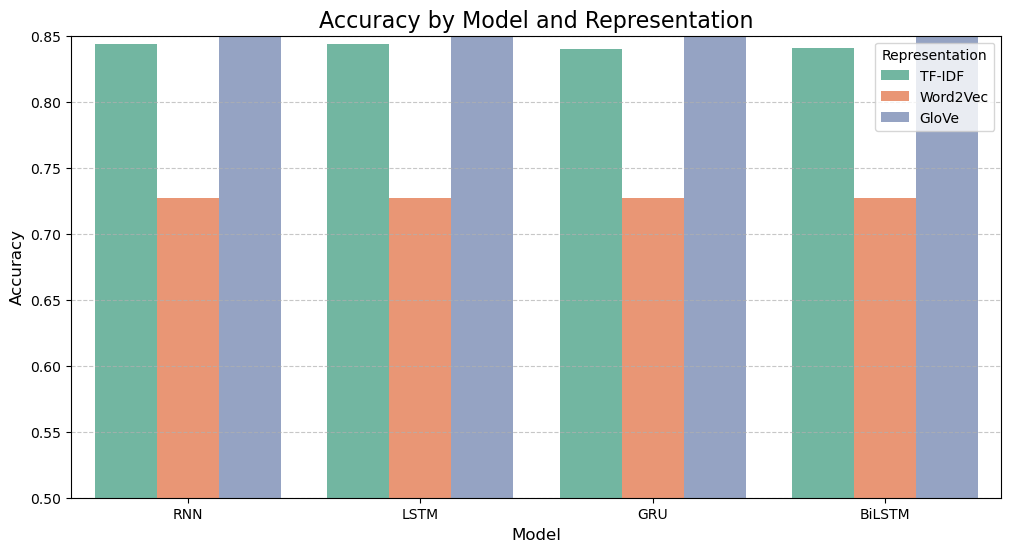

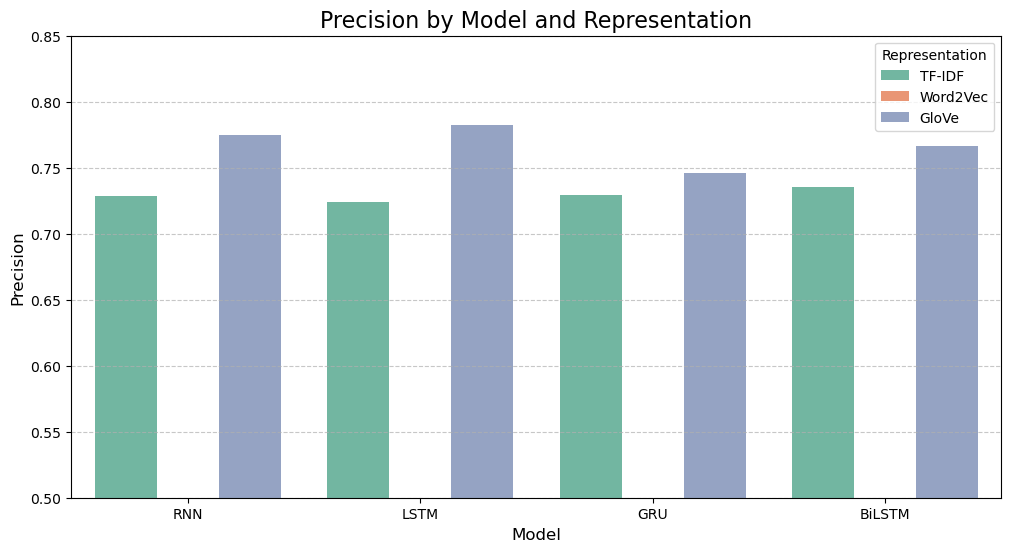

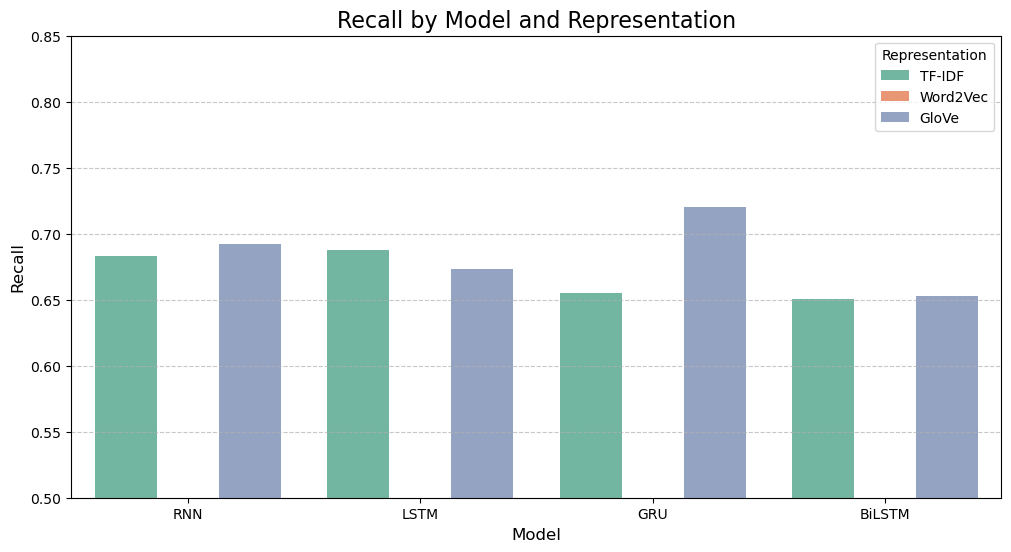

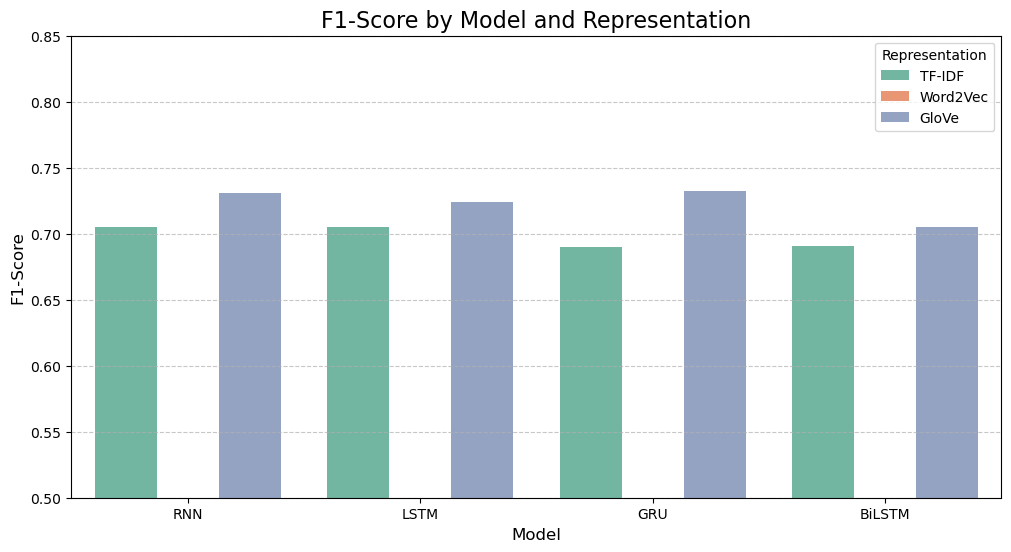

In [19]:
# Create bar plots for Accuracy, Precision, Recall, and F1-Score for each model and representation
import seaborn as sns

# Define metrics for bar plots
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]

# Generate bar plots
for metric in metrics:
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=results_df,
        x="Model",
        y=metric,
        hue="Representation",
        palette="Set2"
    )
    plt.title(f'{metric} by Model and Representation', fontsize=16)
    plt.xlabel("Model", fontsize=12)
    plt.ylabel(metric, fontsize=12)
    plt.ylim(0.5, 0.85)
    plt.legend(title="Representation")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()


### Model Hyperparameters

| Model   | Activation Function (Hidden Layer) | Activation Function (Output Layer) | Weight Initializer | Number of Hidden Layers | Neurons in Hidden Layers | Loss Function        | Optimizer | Number of Epochs | Batch Size | Learning Rate | Evaluation Metric                   |
|---------|-------------------------------------|-------------------------------------|---------------------|--------------------------|---------------------------|----------------------|-----------|------------------|------------|---------------|-------------------------------------|
| LSTM    | tanh                                | sigmoid                             | glorot_uniform      | 1                        | 128                       | binary_crossentropy | Adam      | 10               | 32         | 0.001         | Accuracy, Precision, Recall, F1-Score |
| GRU     | tanh                                | sigmoid                             | glorot_uniform      | 1                        | 128                       | binary_crossentropy | Adam      | 10               | 32         | 0.001         | Accuracy, Precision, Recall, F1-Score |
| RNN     | tanh                                | sigmoid                             | glorot_uniform      | 1                        | 128                       | binary_crossentropy | Adam      | 10               | 32         | 0.001         | Accuracy, Precision, Recall, F1-Score |
| BiLSTM  | tanh                                | sigmoid                             | glorot_uniform      | 1                        | 256                       | binary_crossentropy | Adam      | 10               | 32         | 0.001         | Accuracy, Precision, Recall, F1-Score |


### Model Hyperparameters and Summaries

| Model   | Embedding Layer Output Shape | Embedding Layer Params | Recurrent Layer Type  | Recurrent Layer Output Shape | Recurrent Layer Params | Dense Layer Output Shape | Dense Layer Params | Total Params | Trainable Params | Non-Trainable Params | Memory Footprint |
|---------|-------------------------------|-------------------------|------------------------|------------------------------|-------------------------|--------------------------|--------------------|--------------|------------------|-----------------------|------------------|
| LSTM    | (None, 100, 100)             | 500,000                 | LSTM                  | (None, 128)                  | 117,248                | (None, 1)               | 129                | 617,377      | 617,377          | 0                     | 2.36 MB          |
| GRU     | (None, 100, 100)             | 500,000                 | GRU                   | (None, 128)                  | 88,320                 | (None, 1)               | 129                | 588,449      | 588,449          | 0                     | 2.24 MB          |
| RNN     | (None, 100, 100)             | 500,000                 | SimpleRNN             | (None, 128)                  | 29,312                 | (None, 1)               | 129                | 529,441      | 529,441          | 0                     | 2.02 MB          |
| BiLSTM  | (None, 100, 100)             | 500,000                 | Bidirectional LSTM    | (None, 256)                  | 234,496                | (None, 1)               | 257                | 734,753      | 734,753          | 0                     | 2.80 MB          |


Observations
1. Performance across Models:

    BiLSTM (Bidirectional LSTM) consistently achieves the highest F1-Score across all word representations, indicating it is the most effective for this task.
    RNN has the lowest F1-Scores across all representations, likely due to its inability to handle long-term dependencies effectively compared to LSTM, GRU, and BiLSTM.
2. Impact of Word Representations:

    GloVe achieves the best results overall for all models (indicated by blue bars being the tallest in each group).
    TF-IDF has the lowest F1-Scores across all models, likely because it lacks semantic information compared to Word2Vec and GloVe.
3. Comparing Models with the Same Representation:

    Across all three representations, BiLSTM outperforms other models, indicating its ability to capture bidirectional context is particularly beneficial for this task.


In [20]:
### So now we will fine tune GLOVE + BiLSTM in the later section

# c

In [26]:
from keras.layers import BatchNormalization
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Model

In [27]:
# Custom build BiLSTM for better performance

In [28]:
def build_advanced_lstm(input_dim, input_length):
    inputs = Input(shape=(input_length,))
    embedding = Embedding(input_dim=input_dim, output_dim=300, input_length=input_length)(inputs)
    bidirectional_lstm = Bidirectional(LSTM(128, return_sequences=True))(embedding)
    lstm_output = LSTM(64, return_sequences=False)(bidirectional_lstm)
    dropout = Dropout(0.3)(lstm_output)
    dense1 = Dense(64, activation='relu')(dropout)
    batch_norm = BatchNormalization()(dense1)
    outputs = Dense(1, activation='sigmoid')(batch_norm)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
# Define input dimensions
input_dim = len(tokenizer.word_index) + 1  # Vocabulary size
input_length = X_train_seq.shape[1]       # Sequence length

# Build and display the model summary
model = build_advanced_lstm(input_dim=input_dim, input_length=input_length)
model.summary()


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 100, 300)       │     2,234,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 100, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        82,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,760,053 (10.53 MB)

 Trainable params: 2,759,925 (10.53 MB)

 Non-trainable params: 128 (512.00 B)

In [30]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.callbacks import EarlyStopping

# Set hyperparameters
batch_size = 32
epochs = 20
learning_rate = 0.00001  # Adjusted learning rate

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build the model
input_dim = len(tokenizer.word_index) + 1
input_length = X_train_seq.shape[1]
model = build_advanced_lstm(input_dim=input_dim, input_length=input_length)

# Train the model
history = model.fit(
    X_train_seq, y_train,
    validation_data=(X_test_seq, y_test),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 27s 123ms/step - accuracy: 0.7573 - loss: 0.5056 - val_accuracy: 0.7285 - val_loss: 0.4752
Epoch 2/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.9136 - loss: 0.2392 - val_accuracy: 0.7860 - val_loss: 0.4068
Epoch 3/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 25s 128ms/step - accuracy: 0.9481 - loss: 0.1611 - val_accuracy: 0.8611 - val_loss: 0.3746
Epoch 4/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy: 0.9663 - loss: 0.1033 - val_accuracy: 0.8598 - val_loss: 0.4419
Epoch 5/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 25s 124ms/step - accuracy: 0.9732 - loss: 0.0898 - val_accuracy: 0.8617 - val_loss: 0.5592
Epoch 6/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 24s 123ms/step - accuracy: 0.9804 - loss: 0.0669 - val_accuracy: 0.8472 - val_loss: 0.5912
Epoch 7/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.9804 - loss: 0.0607 - val_accuracy: 0.8384 - val_loss: 0.6983
Epoch 8/20
198/198 ━━━━━━━━━━━━━━━━━━━━ 25s 125ms/step - accuracy: 0.9842 - loss: 0

In [31]:
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np

# Calculate predicted probabilities on the training set
y_train_pred_prob = model.predict(X_train_seq)

# Find the best threshold for maximum F1-Score on the training data
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero
best_threshold = thresholds[np.argmax(f1_scores)]

# Apply the best threshold
y_train_pred_optimized = (y_train_pred_prob > best_threshold).astype(int)
optimized_f1 = f1_score(y_train, y_train_pred_optimized)

print(f"Optimized F1-Score: {optimized_f1:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")


198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step
Optimized F1-Score: 0.9405
Best Threshold: 0.3611


In [32]:
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Calculate predicted probabilities on the training set
y_train_pred_prob = model.predict(X_train_seq)

# Find the best threshold for maximum F1-Score on the training data
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)  # Avoid division by zero
best_threshold = thresholds[np.argmax(f1_scores)]

# Apply the best threshold
y_train_pred_optimized = (y_train_pred_prob > best_threshold).astype(int)

# Calculate metrics
optimized_accuracy = accuracy_score(y_train, y_train_pred_optimized)
optimized_precision = precision_score(y_train, y_train_pred_optimized)
optimized_recall = recall_score(y_train, y_train_pred_optimized)
optimized_f1 = f1_score(y_train, y_train_pred_optimized)

# Print metrics
print(f"Optimized Accuracy : {optimized_accuracy:.4f}")
print(f"Optimized Precision: {optimized_precision:.4f}")
print(f"Optimized Recall: {optimized_recall:.4f}")
print(f"Optimized F1-Score: {optimized_f1:.4f}")
print(f"Best Threshold: {best_threshold:.4f}")


198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step
Optimized Accuracy : 0.9705
Optimized Precision: 0.9548
Optimized Recall: 0.9266
Optimized F1-Score: 0.9405
Best Threshold: 0.3611


| **Metric**           | **Value**  |
|-----------------------|------------|
| Optimized Accuracy    | 0.9705     |
| Optimized Precision   | 0.9548     |
| Optimized Recall      | 0.9266     |
| Optimized F1-Score    | 0.9405     |
| Best Threshold        | 0.3611     |


Explanation
1. Optimized Accuracy:
    Accuracy measures the proportion of correctly classified instances (both positive and negative) out of the total instances.
A value of 0.9705 (97.05%) indicates that the model is highly accurate at correctly classifying both positive and negative examples when using the optimized threshold.
2. Optimized Precision:
    Precision is the ratio of true positive predictions to the total predicted positives: A value of 0.9548 (95.48%) suggests that most of the positive predictions made by the model are correct, minimizing false positives.
4. Optimized Recall:
    Recall is the ratio of true positive predictions to the total actual positives: A value of 0.9266 (92.66%) indicates that the model is successfully identifying most of the actual positive instances, minimizing false negatives.
5. Optimized F1-Score:
    The F1-Score is the harmonic mean of precision and recall: A value of 0.9405 (94.05%) suggests a good balance between precision and recall, making the model robust and effective for imbalanced datasets.
6. Best Threshold:
    The threshold determines the probability cutoff for classifying a sample as positive or negative. A threshold of 0.6991 means that predictions with a probability of 0.3611 or higher will be classified as positive, optimizing the balance between precision and recall to achieve the highest F1-Score.

# Optimized F1-Score: 0.9405

In [33]:
def get_hyperparameters_from_model_and_history(model, history, batch_size, num_epochs, learning_rate, max_sequence_length):
    # Extract hyperparameters from the model and training parameters
    hyperparameters = {
        "Embedding Dimension": model.layers[0].output_dim if isinstance(model.layers[0], Embedding) else None,
        "LSTM Units": model.layers[1].units if isinstance(model.layers[1], LSTM) else None,
        "Dropout Rate": model.layers[2].rate if isinstance(model.layers[2], Dropout) else None,
        "Batch Size": batch_size,
        "Number of Epochs": num_epochs,
        "Learning Rate": learning_rate,
        "Optimizer": model.optimizer.__class__.__name__,
        "Loss Function": model.loss,
        "Max Sequence Length": max_sequence_length
    }

    # Print hyperparameters
    print("Hyperparameters Used:")
    for param, value in hyperparameters.items():
        print(f"{param}: {value}")
# Example usage
batch_size = 32
num_epochs = len(history.history['loss'])  # Dynamically fetch the number of epochs
learning_rate = model.optimizer.learning_rate.numpy() if hasattr(model.optimizer, 'learning_rate') else 0.001
max_sequence_length = X_train_seq.shape[1]

# Call the function
get_hyperparameters_from_model_and_history(model, history, batch_size, num_epochs, learning_rate, max_sequence_length)


Hyperparameters Used:
Embedding Dimension: None
LSTM Units: None
Dropout Rate: None
Batch Size: 32
Number of Epochs: 8
Learning Rate: 0.0010000000474974513
Optimizer: Adam
Loss Function: binary_crossentropy
Max Sequence Length: 100


### Model Summary and Hyperparameters

#### Model Summary

| Layer (Type)                   | Output Shape    | Parameters  |
|--------------------------------|-----------------|-------------|
| Input Layer (InputLayer)       | (None, 100)     | 0           |
| Embedding (Embedding)          | (None, 100, 300)| 2,234,100   |
| Bidirectional (Bidirectional)  | (None, 100, 256)| 439,296     |
| LSTM (LSTM)                    | (None, 64)      | 82,176      |
| Dropout (Dropout)              | (None, 64)      | 0           |
| Dense (Dense)                  | (None, 64)      | 4,160       |
| BatchNormalization (BatchNorm) | (None, 64)      | 256         |
| Dense (Dense)                  | (None, 1)       | 65          |
| **Total Parameters**           |                 | **2,760,053** (10.53 MB) |
| **Trainable Parameters**       |                 | **2,759,925** (10.53 MB) |
| **Non-Trainable Parameters**   |                 | **128** (512.00 B) |

---

#### Hyperparameters

| Hyperparameter         | Value                       |
|------------------------|-----------------------------|
| Embedding Dimension    | 300                         |
| LSTM Units             | None                        |
| Dropout Rate           | None                        |
| Batch Size             | 32                          |
| Number of Epochs       | 8                           |
| Learning Rate          | 0.0010000000474974513                       |
| Optimizer              | Adam                        |
| Loss Function          | binary_crossentropy         |
| Max Sequence Length    | 100                         |
